# Azure Open AI - Demo 3 Document clustering

In [1]:
import numpy as np
import openai
import os
import pandas as pd
import plotly
import sys

import matplotlib.pyplot as plt
%matplotlib inline

from dotenv import load_dotenv
from openai.embeddings_utils import get_embedding
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [3]:
print("openai version =", openai.__version__)

openai version = 0.28.0


In [4]:
load_dotenv("azure.env")

openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

In [5]:
embedding_model = "text-embedding-ada-002"

pd.set_option(
    "display.max_columns", 100, "display.max_rows", 100, "display.max_colwidth", None
)

## 1. Load Data 

In [8]:
!ls documents/cnn.zip -lh

-rwxrwxrwx 1 root root 19M Sep  8 12:00 documents/cnn.zip


In [9]:
os.chdir("documents")
!unzip cnn.zip
os.chdir("..")

Archive:  cnn.zip
  inflating: cnn.csv                 


In [10]:
!ls documents/cnn.csv -lh

-rwxrwxrwx 1 root root 48M Mar  4  2023 documents/cnn.csv


In [12]:
data_df = pd.read_csv("documents/cnn.csv")

df = data_df.sample(50, random_state=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 2365 to 8412
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          50 non-null     object
 1   article     50 non-null     object
 2   highlights  50 non-null     object
dtypes: object(3)
memory usage: 1.6+ KB


In [13]:
df.head(3)

,id,article,highlights
2365,31da329bfbf7c248bd47880ad7e780abe8c7fd7c,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made the speech to a packed auditorium of men and women in his home country. It is the latest controversial teaching put forward by Dehnavi, who also warned that if women did not wear the hijab - the veil covering the hair and chest - properly, they could inadvertently cause some men to become homosexual. Islamic cleric Dehnavi is a celebrity in his native Iran, giving speeches on relationships and family values . While thinking about another woman while having sex with your wife is not a sin, the Iranian ayatollah preaches, if she becomes pregnant it will mean the child will be gay. Homosexuality is punishable by death in the state . On past occasions He has preached that women must provide sex to their husbands at all times - and said women who are better educated or are financially independent 'harm men's authority'. 'One of the other duties of women in regard to their men is to take care of their men’s instinctive needs [sexual drive]', the cleric said in a report by The Clarion Project, an organisation against extremism. 'Do not break their pride and [you must] be more sensitive toward them' During another speech, the ayatollah explain that it is not a sin for a man to think about another woman while he is having sex with his partner, but if she becomes pregnant as a result the child will be gay. Incorrectly wearing the hijab, Dehnavi also warns, could lead to some men becoming homosexual. Hundreds of women attend the lectures and speeches of the Muslim cleric, whose is also regularly shown on state TV . The statements, thought to have been made in 2012 and 2013, came to light after being shared by Gay Star News this week. Homosexual acts are punishable by death in Iran, with gay and lesbian people forced to hide their sexuality. A man involved in the 'dominant' role in sodomy faces being flogged up to 100 times if he is unmarried and the sex is consensual, while the man playing the 'passive' can still be put to death regardless of his marriage status, according to a report in The Guardian. Lesbians faced being whipped 100 times, but sex between two women can also lead to the death penalty if the act is committed four times. Following his teachings, Dehavni says, will ultimately lead to 'peace on earth'. In another speech he controversially suggested that women should always be sexually available for their husbands . Men become 'saturated' if they have too much sex, Dehavni warns - suggesting becoming intimate once or twice a week is enough. He also says women can make their husbands aroused by showing off their armpits . Dehavni is a celebrated cleric in Iran, whose speeches on family life and marital affairs are shown on state TV and who people queue up for tickets to see him speak live, according to Iran Wire. The 53-year-old grandfather has himself been married for 30 years . In other speeches he warns Iranian couples not to have too much sex: '.. only once or twice a week, not every day. Otherwise the wan will become saturated.' He also suggests paler women wear black underwear and show off the most attractive parts of their bodies - their armpits and chest - to entice their husbands. By perfecting the art of lovemaking, he suggests, couples will have bigger families with strong Muslim values which will ultimately lead to peace on earth.",Ayatollah Hossein Dehnavi made statement during marriage advice speech .\nAlso claims women not wearing hijab properly could make men gay .\nHomosexuals face persecution in Iran under strict Islamic regime .
10729,8d1da9b0197d9c733db56bdfa62332d04144398d,Aston Villa may be able to sign Cordoba striker Florin Andone for as little as £2.5million. The Spanish side are poised to be relegated and need to raise funds. Sportsmai

In [14]:
df.shape

(50, 3)

## 2. Create Embeddings 

In [15]:
# limit article size
max_size = 512

df["article_short"] = (
    df["article"].str.split(n=max_size).str[:max_size].str.join(" ")
)

df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 2365 to 8412
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             50 non-null     object
 1   article        50 non-null     object
 2   highlights     50 non-null     object
 3   article_short  50 non-null     object
dtypes: object(4)
memory usage: 2.0+ KB


,id,article,highlights,article_short
2365,31da329bfbf7c248bd47880ad7e780abe8c7fd7c,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made the speech to a packed auditorium of men and women in his home country. It is the latest controversial teaching put forward by Dehnavi, who also warned that if women did not wear the hijab - the veil covering the hair and chest - properly, they could inadvertently cause some men to become homosexual. Islamic cleric Dehnavi is a celebrity in his native Iran, giving speeches on relationships and family values . While thinking about another woman while having sex with your wife is not a sin, the Iranian ayatollah preaches, if she becomes pregnant it will mean the child will be gay. Homosexuality is punishable by death in the state . On past occasions He has preached that women must provide sex to their husbands at all times - and said women who are better educated or are financially independent 'harm men's authority'. 'One of the other duties of women in regard to their men is to take care of their men’s instinctive needs [sexual drive]', the cleric said in a report by The Clarion Project, an organisation against extremism. 'Do not break their pride and [you must] be more sensitive toward them' During another speech, the ayatollah explain that it is not a sin for a man to think about another woman while he is having sex with his partner, but if she becomes pregnant as a result the child will be gay. Incorrectly wearing the hijab, Dehnavi also warns, could lead to some men becoming homosexual. Hundreds of women attend the lectures and speeches of the Muslim cleric, whose is also regularly shown on state TV . The statements, thought to have been made in 2012 and 2013, came to light after being shared by Gay Star News this week. Homosexual acts are punishable by death in Iran, with gay and lesbian people forced to hide their sexuality. A man involved in the 'dominant' role in sodomy faces being flogged up to 100 times if he is unmarried and the sex is consensual, while the man playing the 'passive' can still be put to death regardless of his marriage status, according to a report in The Guardian. Lesbians faced being whipped 100 times, but sex between two women can also lead to the death penalty if the act is committed four times. Following his teachings, Dehavni says, will ultimately lead to 'peace on earth'. In another speech he controversially suggested that women should always be sexually available for their husbands . Men become 'saturated' if they have too much sex, Dehavni warns - suggesting becoming intimate once or twice a week is enough. He also says women can make their husbands aroused by showing off their armpits . Dehavni is a celebrated cleric in Iran, whose speeches on family life and marital affairs are shown on state TV and who people queue up for tickets to see him speak live, according to Iran Wire. The 53-year-old grandfather has himself been married for 30 years . In other speeches he warns Iranian couples not to have too much sex: '.. only once or twice a week, not every day. Otherwise the wan will become saturated.' He also suggests paler women wear black underwear and show off the most attractive parts of their bodies - their armpits and chest - to entice their husbands. By perfecting the art of lovemaking, he suggests, couples will have bigger families with strong Muslim values which will ultimately lead to peace on earth.",Ayatollah Hossein Dehnavi made statement during marriage advice speech .\nAlso claims women not wearing hijab properly could make men gay .\nHomosexuals face persecution in Iran under strict Islamic regime .,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made t

In [16]:
# create embeddings for each article 
df["babbage_search_embedding"] = df["article_short"].apply(
    lambda x: get_embedding(x, engine=embedding_model))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 2365 to 8412
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        50 non-null     object
 1   article                   50 non-null     object
 2   highlights                50 non-null     object
 3   article_short             50 non-null     object
 4   babbage_search_embedding  50 non-null     object
dtypes: object(5)
memory usage: 2.3+ KB


In [17]:
df.head(1)

,id,article,highlights,article_short,babbage_search_embedding
2365,31da329bfbf7c248bd47880ad7e780abe8c7fd7c,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made the speech to a packed auditorium of men and women in his home country. It is the latest controversial teaching put forward by Dehnavi, who also warned that if women did not wear the hijab - the veil covering the hair and chest - properly, they could inadvertently cause some men to become homosexual. Islamic cleric Dehnavi is a celebrity in his native Iran, giving speeches on relationships and family values . While thinking about another woman while having sex with your wife is not a sin, the Iranian ayatollah preaches, if she becomes pregnant it will mean the child will be gay. Homosexuality is punishable by death in the state . On past occasions He has preached that women must provide sex to their husbands at all times - and said women who are better educated or are financially independent 'harm men's authority'. 'One of the other duties of women in regard to their men is to take care of their men’s instinctive needs [sexual drive]', the cleric said in a report by The Clarion Project, an organisation against extremism. 'Do not break their pride and [you must] be more sensitive toward them' During another speech, the ayatollah explain that it is not a sin for a man to think about another woman while he is having sex with his partner, but if she becomes pregnant as a result the child will be gay. Incorrectly wearing the hijab, Dehnavi also warns, could lead to some men becoming homosexual. Hundreds of women attend the lectures and speeches of the Muslim cleric, whose is also regularly shown on state TV . The statements, thought to have been made in 2012 and 2013, came to light after being shared by Gay Star News this week. Homosexual acts are punishable by death in Iran, with gay and lesbian people forced to hide their sexuality. A man involved in the 'dominant' role in sodomy faces being flogged up to 100 times if he is unmarried and the sex is consensual, while the man playing the 'passive' can still be put to death regardless of his marriage status, according to a report in The Guardian. Lesbians faced being whipped 100 times, but sex between two women can also lead to the death penalty if the act is committed four times. Following his teachings, Dehavni says, will ultimately lead to 'peace on earth'. In another speech he controversially suggested that women should always be sexually available for their husbands . Men become 'saturated' if they have too much sex, Dehavni warns - suggesting becoming intimate once or twice a week is enough. He also says women can make their husbands aroused by showing off their armpits . Dehavni is a celebrated cleric in Iran, whose speeches on family life and marital affairs are shown on state TV and who people queue up for tickets to see him speak live, according to Iran Wire. The 53-year-old grandfather has himself been married for 30 years . In other speeches he warns Iranian couples not to have too much sex: '.. only once or twice a week, not every day. Otherwise the wan will become saturated.' He also suggests paler women wear black underwear and show off the most attractive parts of their bodies - their armpits and chest - to entice their husbands. By perfecting the art of lovemaking, he suggests, couples will have bigger families with strong Muslim values which will ultimately lead to peace on earth.",Ayatollah Hossein Dehnavi made statement during marriage advice speech .\nAlso claims women not wearing hijab properly could make men gay .\nHomosexuals face persecution in Iran under strict Islamic regime .,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity

In [18]:
df.dtypes

id                          object
article                     object
highlights                  object
article_short               object
babbage_search_embedding    object
dtype: object

## 3. Clustering Analysis

In [19]:
n_clusters = 6

embedding_matrix = np.vstack(df.babbage_search_embedding.values)

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, random_state=123456)
kmeans.fit(embedding_matrix)
labels = kmeans.labels_
df["cluster_label"] = labels

df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 2365 to 8412
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        50 non-null     object
 1   article                   50 non-null     object
 2   highlights                50 non-null     object
 3   article_short             50 non-null     object
 4   babbage_search_embedding  50 non-null     object
 5   cluster_label             50 non-null     int32 
dtypes: int32(1), object(5)
memory usage: 2.5+ KB


,id,article,highlights,article_short,babbage_search_embedding,cluster_label
2365,31da329bfbf7c248bd47880ad7e780abe8c7fd7c,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made the speech to a packed auditorium of men and women in his home country. It is the latest controversial teaching put forward by Dehnavi, who also warned that if women did not wear the hijab - the veil covering the hair and chest - properly, they could inadvertently cause some men to become homosexual. Islamic cleric Dehnavi is a celebrity in his native Iran, giving speeches on relationships and family values . While thinking about another woman while having sex with your wife is not a sin, the Iranian ayatollah preaches, if she becomes pregnant it will mean the child will be gay. Homosexuality is punishable by death in the state . On past occasions He has preached that women must provide sex to their husbands at all times - and said women who are better educated or are financially independent 'harm men's authority'. 'One of the other duties of women in regard to their men is to take care of their men’s instinctive needs [sexual drive]', the cleric said in a report by The Clarion Project, an organisation against extremism. 'Do not break their pride and [you must] be more sensitive toward them' During another speech, the ayatollah explain that it is not a sin for a man to think about another woman while he is having sex with his partner, but if she becomes pregnant as a result the child will be gay. Incorrectly wearing the hijab, Dehnavi also warns, could lead to some men becoming homosexual. Hundreds of women attend the lectures and speeches of the Muslim cleric, whose is also regularly shown on state TV . The statements, thought to have been made in 2012 and 2013, came to light after being shared by Gay Star News this week. Homosexual acts are punishable by death in Iran, with gay and lesbian people forced to hide their sexuality. A man involved in the 'dominant' role in sodomy faces being flogged up to 100 times if he is unmarried and the sex is consensual, while the man playing the 'passive' can still be put to death regardless of his marriage status, according to a report in The Guardian. Lesbians faced being whipped 100 times, but sex between two women can also lead to the death penalty if the act is committed four times. Following his teachings, Dehavni says, will ultimately lead to 'peace on earth'. In another speech he controversially suggested that women should always be sexually available for their husbands . Men become 'saturated' if they have too much sex, Dehavni warns - suggesting becoming intimate once or twice a week is enough. He also says women can make their husbands aroused by showing off their armpits . Dehavni is a celebrated cleric in Iran, whose speeches on family life and marital affairs are shown on state TV and who people queue up for tickets to see him speak live, according to Iran Wire. The 53-year-old grandfather has himself been married for 30 years . In other speeches he warns Iranian couples not to have too much sex: '.. only once or twice a week, not every day. Otherwise the wan will become saturated.' He also suggests paler women wear black underwear and show off the most attractive parts of their bodies - their armpits and chest - to entice their husbands. By perfecting the art of lovemaking, he suggests, couples will have bigger families with strong Muslim values which will ultimately lead to peace on earth.",Ayatollah Hossein Dehnavi made statement during marriage advice speech .\nAlso claims women not wearing hijab properly could make men gay .\nHomosexuals face persecution in Iran under strict Islamic regime .,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnav

Text(0.5, 1.0, 'Clusters Identified Using t-SNE')

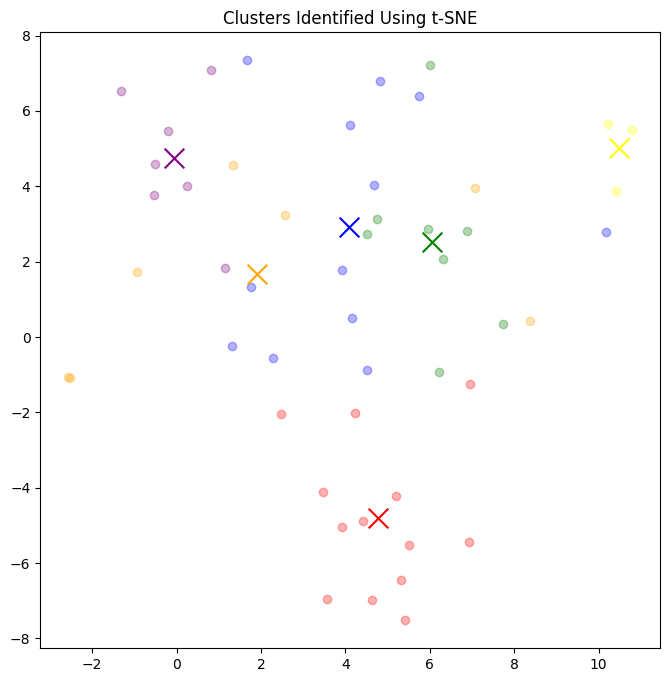

In [20]:
# clustering using t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=0, init="random")
vis_dims2 = tsne.fit_transform(embedding_matrix)
x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

# creating scattering plots
plt.figure(figsize=(8, 8))
for category, color in enumerate(
    ["purple", "green", "red", "blue", "yellow", "orange"]
):
    xs = np.array(x)[df.cluster_label == category]
    ys = np.array(y)[df.cluster_label == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)
    avg_x = xs.mean()
    avg_y = ys.mean()
    plt.scatter(avg_x, avg_y, marker="x", color=color, s=200)

plt.title("Clusters Identified Using t-SNE")

## 4. Summarize Each Article With OpenAI

In [21]:
model = "text-davinci-003"

In [22]:
def summarize_text(text):
    """This function submits summarization api calls."""
    prompt = f"""Summarize below text in 2 short sentences:
                 
                 ###{text}
              """
    response = openai.Completion.create(
        engine=model,
        prompt=prompt,
        temperature=0.7,
        max_tokens=300,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )

    return response["choices"][0]["text"].replace("\n", "")

In [23]:
df["summary"] = df["article_short"].apply(lambda x: summarize_text(x))

df.head(1)

InvalidRequestError: The response was filtered due to the prompt triggering Azure OpenAI’s content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766

## 5. Show Cluster Topics With Sample Summaries

In [ ]:
article_per_cluster = 4

for i in range(n_clusters):
    print(f"Cluster {i+1} Topic:", end=" ")
    
    articles = "\n".join(
        df[df.cluster_label == i]
        .summary.str.replace("\n\n", ":  ")
        .sample(article_per_cluster, random_state=0)
        .values
    )
    # create prompt
    prompt = f"""The following articles belong to which news topic?
                 
                 ###articles:{articles}
                 
                 News Topic:
              """
    # summarize via openai
    response = openai.Completion.create(
        engine=model,
        prompt=prompt,
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))
    print("\n")
    # show sample summaries
    sample_cluster_rows = subset_df[df.cluster_label == i].sample(
        article_per_cluster, random_state=0
    )
    for j in range(article_per_cluster):
        print(str(j + 1), end=": ")
        print(sample_cluster_rows.summary.values[j])
        print("\n")
        print(sample_cluster_rows.article.str[:70].values[j])

    print("-" * 80 + "\n")